In [69]:
import os
import pandas as pd
import numpy as np
import warnings

## 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 전처리 및 변환
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

## 모델 학습 및 평가 도구
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

## 분류 모델
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## 모델 평가 지표
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
## 통계 모델링
import statsmodels.api as sm

## Kaggle
import kagglehub


warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
warnings.filterwarnings('ignore', category=FutureWarning, module='numpy')


path = kagglehub.dataset_download("mysarahmadbhat/lung-cancer")
files = os.listdir(path)
for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(path, file)
        data = pd.read_csv(file_path)

In [70]:
data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [72]:
data.shape

(309, 16)

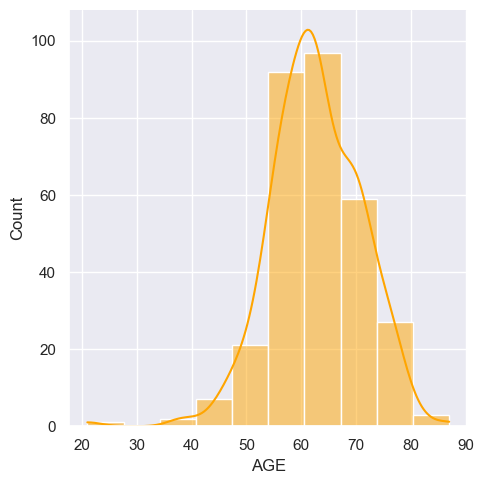

In [73]:
# 나이 분포
sns.set(rc={"figure.figsize":(6,4)})
sns.displot(data["AGE"], kde=True, color="orange", bins=10)

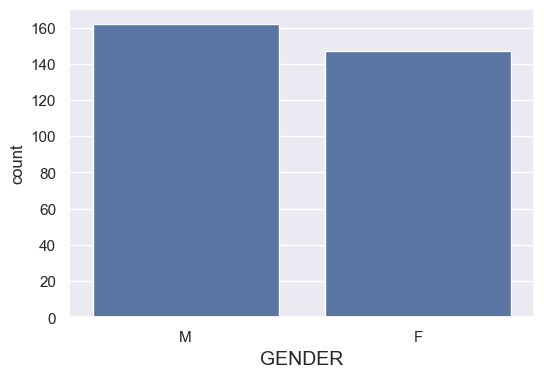

In [74]:
# 성별 분포
plt.figure(figsize=(6,4))
sns.countplot(x = "GENDER", data=data)
plt.xlabel("GENDER", fontsize=14)
plt.show()

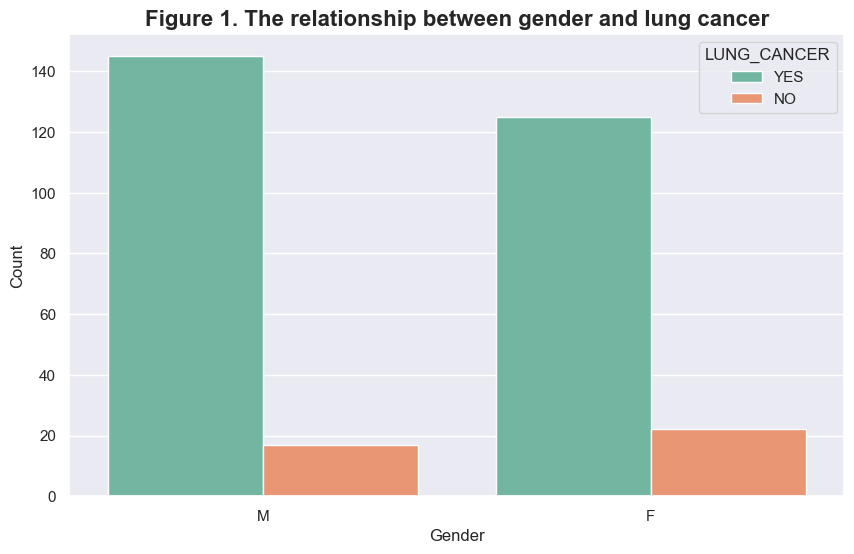

<Figure size 1000x600 with 0 Axes>

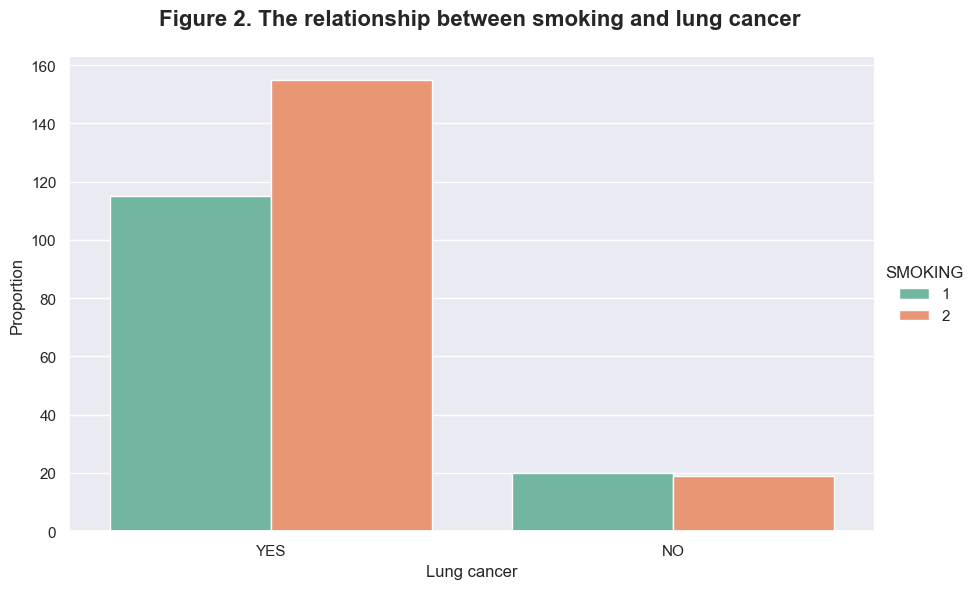

In [75]:
# Figure 1
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='GENDER', hue='LUNG_CANCER', palette='Set2')
plt.title('Figure 1. The relationship between gender and lung cancer', fontsize=16, weight='bold')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Figure 2
plt.figure(figsize=(10, 6))
sns.catplot(
    data=data, 
    x='LUNG_CANCER', 
    hue='SMOKING', 
    kind='count', 
    height=6, 
    aspect=1.5, 
    palette='Set2'
)
plt.subplots_adjust(top=0.9)
plt.suptitle('Figure 2. The relationship between smoking and lung cancer', fontsize=16, weight='bold')
plt.xlabel('Lung cancer')
plt.ylabel('Proportion')
plt.show()


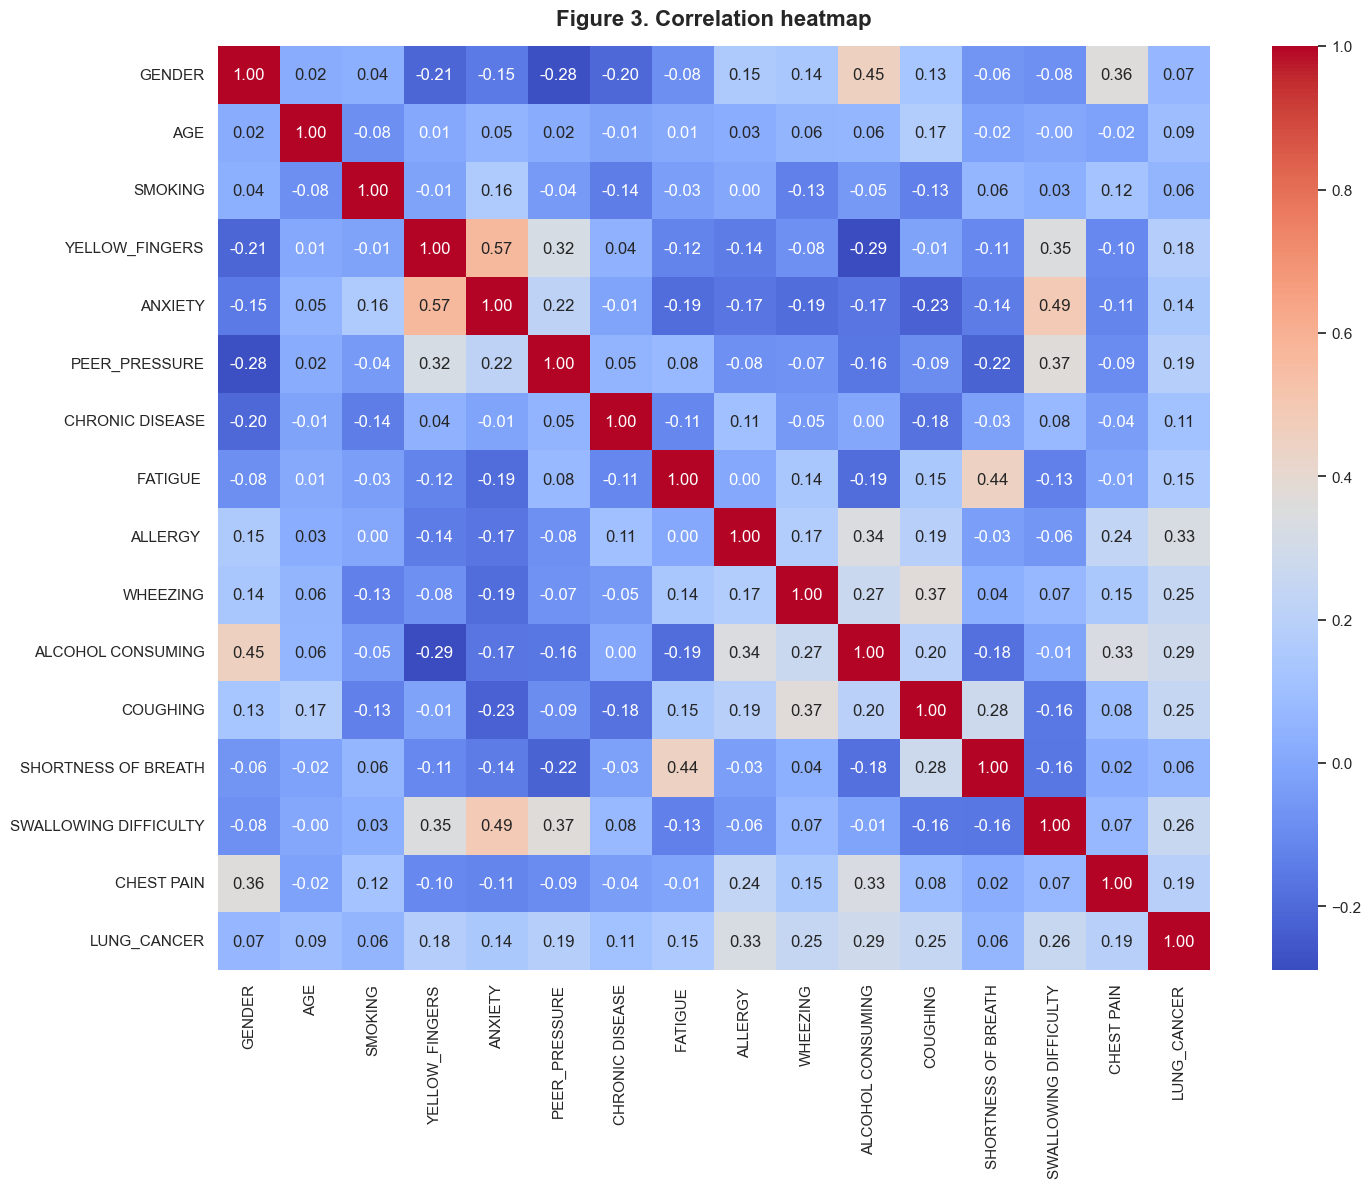

상관계수 높은 변수 쌍:
GENDER               YELLOW_FINGERS        -0.212959
YELLOW_FINGERS       GENDER                -0.212959
PEER_PRESSURE        SHORTNESS OF BREATH   -0.220175
SHORTNESS OF BREATH  PEER_PRESSURE         -0.220175
ANXIETY              COUGHING              -0.225644
COUGHING             ANXIETY               -0.225644
GENDER               PEER_PRESSURE         -0.275564
PEER_PRESSURE        GENDER                -0.275564
YELLOW_FINGERS       ALCOHOL CONSUMING     -0.289025
ALCOHOL CONSUMING    YELLOW_FINGERS        -0.289025
dtype: float64


In [76]:
label_encoder = LabelEncoder()
data['LUNG_CANCER'] = label_encoder.fit_transform(data['LUNG_CANCER'])
data['GENDER'] = label_encoder.fit_transform(data['GENDER'])

numeric_data = data.select_dtypes(include=[np.number])
corr = numeric_data.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Figure 3. Correlation heatmap', fontsize=16, weight='bold', pad=15)
plt.show()


# 다중공선성이 의심되는 변수 확인
high_corr_pairs = corr.unstack().sort_values(kind="quicksort", ascending=False)
print("상관계수 높은 변수 쌍:")
print(high_corr_pairs[high_corr_pairs < 1].tail(10))  # 상위 상관 변수 확인

다중공선성...

In [77]:
X = data.drop('LUNG_CANCER', axis=1)
y = data['LUNG_CANCER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)

#표준화 (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 학습 데이터로 스케일링 학습
X_test_scaled = scaler.transform(X_test)

# PCA 적용
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  

print("PCA 적용된 학습 데이터 Shape:", X_train_pca.shape)
print("PCA 적용된 테스트 데이터 Shape:", X_test_pca.shape)

PCA 적용된 학습 데이터 Shape: (247, 15)
PCA 적용된 테스트 데이터 Shape: (62, 15)


In [78]:
# Explained Variance Ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

Explained Variance Ratios: [0.20864273 0.12600725 0.10057093 0.08888998 0.07341271 0.06410165
 0.05625782 0.05493622 0.04608713 0.0413602  0.03826112 0.03419589
 0.02888732 0.02126843 0.01712062]


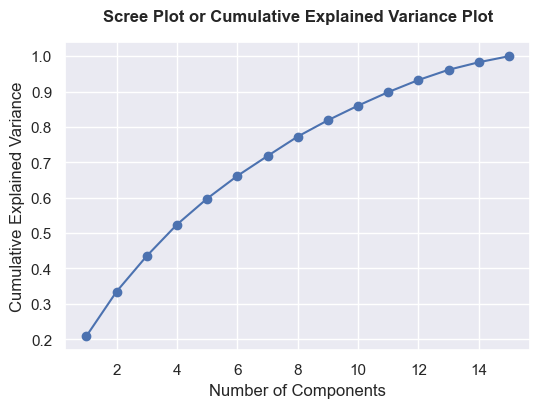

In [79]:
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot or Cumulative Explained Variance Plot', weight='bold', pad=15)
plt.grid(True)
plt.show()

In [80]:
# PCA를 활용한 데이터 차원 축소 과정
desired_variance = 0.95  # 95% 분산 유지
num_components = np.argmax(cumulative_variance >= desired_variance) + 1
print(f"\nNumber of components selected for {desired_variance * 100}% variance: {num_components}")


Number of components selected for 95.0% variance: 13


In [81]:
# 선택한 주성분 개수로 PCA 재적용
pca = PCA(n_components=num_components)
X_train_pca_selected = pca.fit_transform(X_train_scaled)
X_test_pca_selected = pca.transform(X_test_scaled)

In [82]:
print(f"\nFinal shape of training data: {X_train_pca_selected.shape}")
print(f"Final shape of testing data: {X_test_pca_selected.shape}")


Final shape of training data: (247, 13)
Final shape of testing data: (62, 13)


### Logit

In [83]:
# 상수열 추가 (절편을 위한)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Logit 모델 학습
logit_model = sm.Logit(y_train, X_train_const).fit()

# 테스트 데이터 예측
logit_preds_prob = logit_model.predict(X_test_const)
logit_preds = (logit_preds_prob > 0.5).astype(int)

# 모델 평가
logit_auc = roc_auc_score(y_test, logit_preds_prob)
logit_confusion = confusion_matrix(y_test, logit_preds)
logit_class_report = classification_report(y_test, logit_preds)

print("Logit AUC:", logit_auc)
print("Confusion Matrix:\n", logit_confusion)
print("Classification Report:\n", logit_class_report)


Optimization terminated successfully.
         Current function value: 0.142794
         Iterations 10
Logit AUC: 0.9560185185185185
Confusion Matrix:
 [[ 6  2]
 [ 3 51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.96      0.94      0.95        54

    accuracy                           0.92        62
   macro avg       0.81      0.85      0.83        62
weighted avg       0.92      0.92      0.92        62



In [84]:
# Logit 모델 요약
logit_summary = logit_model.summary2().tables[1]

logit_df = pd.DataFrame({
    "coef": logit_summary["Coef."],
    "std error": logit_summary["Std.Err."],
    "p-value": logit_summary["P>|z|"],
    "2.5%": logit_summary["[0.025"],
    "97.5%": logit_summary["0.975]"]
})
logit_df

,coef,std error,p-value,2.5%,97.5%
const,-31.016515,6.679435,0.000003,-44.107966,-17.925064
GENDER,-0.665854,0.810203,0.411170,-2.253823,0.922115
AGE,0.008286,0.038215,0.828348,-0.066614,0.083186
SMOKING,1.405057,0.833502,0.091848,-0.228576,3.038690
YELLOW_FINGERS,1.492293,0.892733,0.094603,-0.257431,3.242017
ANXIETY,1.591538,1.061629,0.133835,-0.489216,3.672292
PEER_PRESSURE,1.962979,0.779642,0.011809,0.434908,3.491049
CHRONIC DISEASE,2.746134,0.995289,0.005796,0.795403,4.696865
FATIGUE,3.162741,1.014178,0.001818,1.174988,5.150493
ALLERGY,1.731837,0.919127,0.059535,-0.069619,3.533292


In [85]:
# Logit 모델 AIC, BIC
logit_aic = logit_model.aic
logit_bic = logit_model.bic
print("Logit AIC:", logit_aic)
print("Logit BIC:", logit_bic)

Logit AIC: 102.54001933694853
Logit BIC: 158.69023272299617


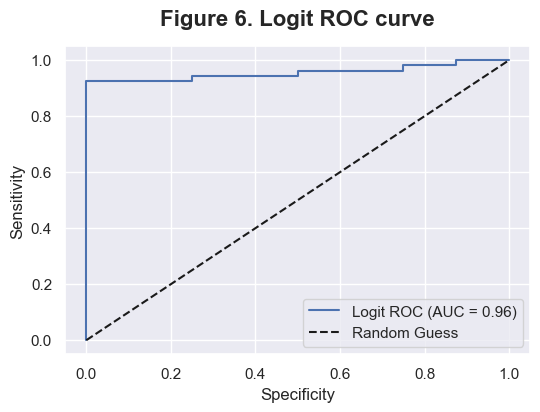

In [86]:
# Logit ROC 곡선
logit_fpr, logit_tpr, _ = roc_curve(y_test, logit_preds_prob)
logit_roc_auc = auc(logit_fpr, logit_tpr)

plt.figure()
plt.plot(logit_fpr, logit_tpr, label=f'Logit ROC (AUC = {logit_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Figure 6. Logit ROC curve', fontsize=16 ,weight='bold', pad=15)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right')
plt.show()

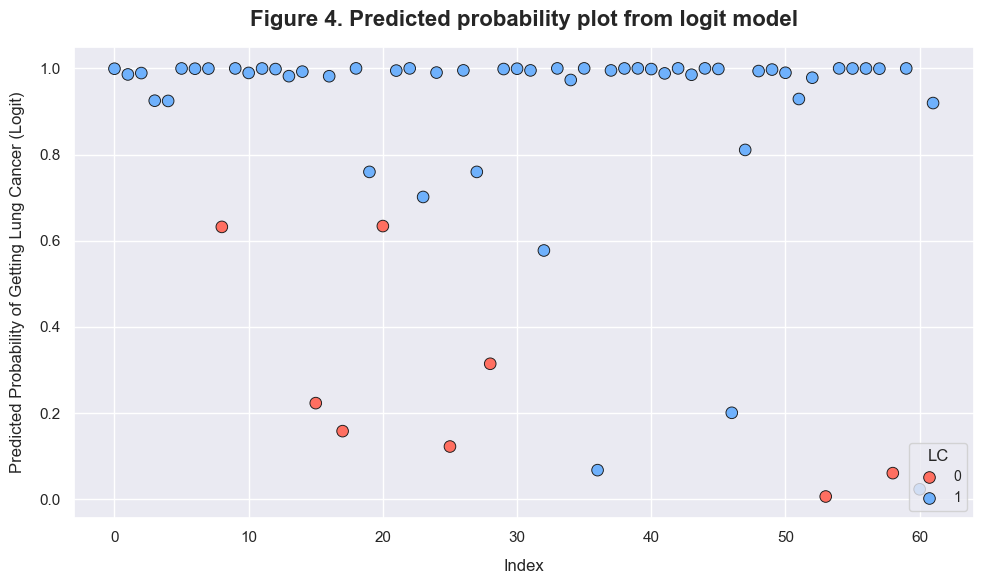

In [87]:
# 예측 확률 및 실제값 정리
data_logit = pd.DataFrame({
    'Index': range(len(logit_preds_prob)),
    'Predicted Probability': logit_preds_prob,
    'LC': y_test
})

# Logit 모델 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_logit,
    x='Index',
    y='Predicted Probability',
    hue='LC',
    palette={0: '#FF6F61', 1: '#6FB1FC'},
    edgecolor='k',
    s=70 
)
plt.title('Figure 4. Predicted probability plot from logit model', fontsize=16, weight='bold', pad=15)
plt.xlabel('Index', fontsize=12, labelpad=10)
plt.ylabel('Predicted Probability of Getting Lung Cancer (Logit)', fontsize=12, labelpad=10)
plt.legend(title='LC', loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

### Probit

In [88]:
# Probit 모델 학습
probit_model = sm.Probit(y_train, X_train_const).fit()

# 테스트 데이터 예측
probit_preds_prob = probit_model.predict(X_test_const)
probit_preds = (probit_preds_prob > 0.5).astype(int)

# 모델 평가
probit_auc = roc_auc_score(y_test, probit_preds_prob)
probit_confusion = confusion_matrix(y_test, probit_preds)
probit_class_report = classification_report(y_test, probit_preds)

print("Probit AUC:", probit_auc)
print("Confusion Matrix:\n", probit_confusion)
print("Classification Report:\n", probit_class_report)


Optimization terminated successfully.
         Current function value: 0.141064
         Iterations 10
Probit AUC: 0.9537037037037037
Confusion Matrix:
 [[ 6  2]
 [ 3 51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.96      0.94      0.95        54

    accuracy                           0.92        62
   macro avg       0.81      0.85      0.83        62
weighted avg       0.92      0.92      0.92        62



In [89]:
# Probit 모델 요약
probit_summary = probit_model.summary2().tables[1]

probit_df = pd.DataFrame({
    "coef": probit_summary["Coef."],
    "std error": probit_summary["Std.Err."],
    "p-value": probit_summary["P>|z|"],
    "2.5%": probit_summary["[0.025"],
    "97.5%": probit_summary["0.975]"]
})
probit_df

,coef,std error,p-value,2.5%,97.5%
const,-17.029992,3.452097,8.088015e-07,-23.795977,-10.264007
GENDER,-0.310270,0.439598,4.803102e-01,-1.171866,0.551326
AGE,0.002565,0.020759,9.016758e-01,-0.038121,0.043251
SMOKING,0.831752,0.459548,7.030559e-02,-0.068945,1.732449
YELLOW_FINGERS,0.799195,0.472416,9.070001e-02,-0.126724,1.725114
ANXIETY,0.869242,0.561604,1.216741e-01,-0.231481,1.969965
PEER_PRESSURE,1.120440,0.441180,1.109654e-02,0.255743,1.985137
CHRONIC DISEASE,1.512017,0.536853,4.855808e-03,0.459805,2.564229
FATIGUE,1.868643,0.568098,1.004380e-03,0.755191,2.982094
ALLERGY,0.956083,0.508017,5.983719e-02,-0.039611,1.951777


In [90]:
# Probit 모델 AIC, BIC
probit_aic = probit_model.aic
probit_bic = probit_model.bic
print("Probit AIC:", probit_aic)
print("Probit BIC:", probit_bic)

Probit AIC: 101.68581450833673
Probit BIC: 157.83602789438436


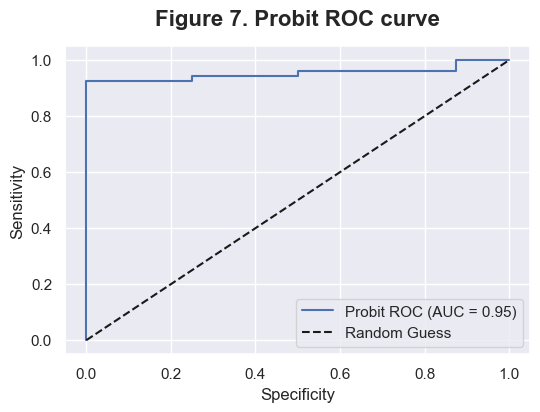

In [91]:
# Probit ROC 곡선
probit_fpr, probit_tpr, _ = roc_curve(y_test, probit_preds_prob)
probit_roc_auc = auc(probit_fpr, probit_tpr)

# Probit ROC 곡선
plt.figure()
plt.plot(probit_fpr, probit_tpr, label=f'Probit ROC (AUC = {probit_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Figure 7. Probit ROC curve', fontsize=16 ,weight='bold', pad=15)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right')
plt.show()

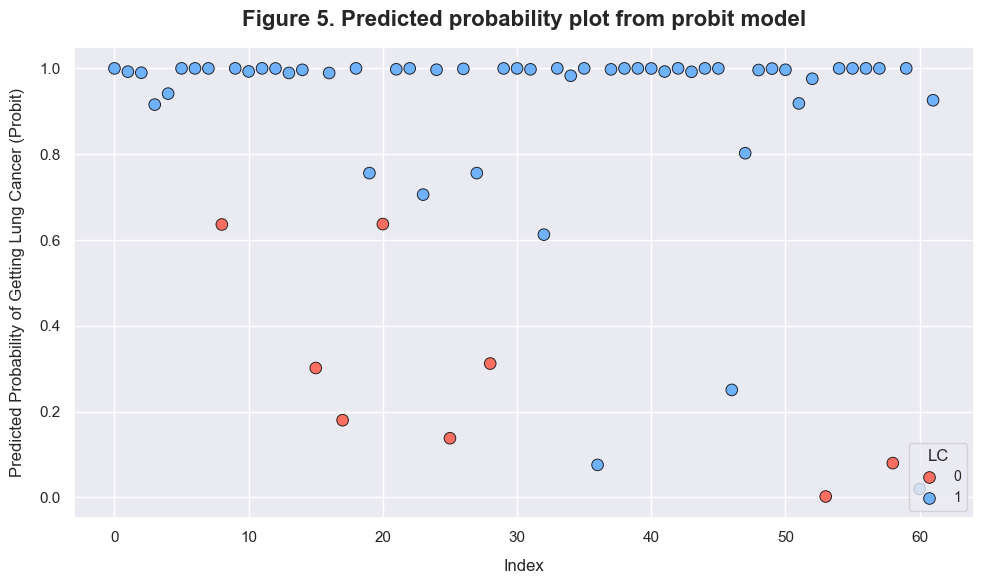

In [92]:
# 예측 확률 및 실제값 정리
data_probit = pd.DataFrame({
    'Index': range(len(probit_preds_prob)),
    'Predicted Probability': probit_preds_prob,
    'LC': y_test
})

# Probit 모델 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_probit,
    x='Index',
    y='Predicted Probability',
    hue='LC',
    palette={0: '#FF6F61', 1: '#6FB1FC'}, 
    edgecolor='k',
    s=70 
)
plt.title('Figure 5. Predicted probability plot from probit model', fontsize=16, weight='bold', pad=15)
plt.xlabel('Index', fontsize=12, labelpad=10)
plt.ylabel('Predicted Probability of Getting Lung Cancer (Probit)', fontsize=12, labelpad=10)
plt.legend(title='LC', loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

## ML

In [ ]:
from sklearn.model_selection import cross_val_score

## model 예측 정확도 (train / test / cross-validation) 출력 함수
def model_accuracy(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    ## 정확도
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    # 교차 검증(cross validation) -> 과적합 해소
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score = cv_scores.mean()
    

    accuracy_df = pd.DataFrame({
        'Train': [train_accuracy],
        'Test': [test_accuracy],
        '교차 검증': [mean_cv_score]
    }, index=['Accuracy'])
    return accuracy_df

### Decision Tree

In [94]:
def decision_tree(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(), 
        DecisionTreeClassifier(random_state=42, criterion='entropy')
    )
    params = {
        "decisiontreeclassifier__max_depth" : [3,4,5,6,7], # 트리의 최대 깊이
        "decisiontreeclassifier__min_samples_split" :[2,3] # 분할을 위한 최소 샘플 수
    }
    clf = RandomizedSearchCV(
        pipe, 
        param_distributions=params, 
        n_iter=10,  # 랜덤 탐색 횟수
        cv=5, # 폴드 수
        scoring='accuracy', # 평가 지표
        n_jobs=-1, # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model


In [95]:
dt = decision_tree(X_train, y_train)
print(dt)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        random_state=42))])


In [118]:
dt_acc = model_accuracy(dt, X_train, y_train, X_test, y_test)
dt_acc

,Train,Test,교차 검증
Accuracy,0.91498,0.822581,0.894776


### RandomForest

In [97]:
def random_forest_small_data(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(),
        RandomForestClassifier(random_state=42)
    )
    params = {
        "randomforestclassifier__n_estimators": [10, 50],
        "randomforestclassifier__max_depth": [3, 5, 10], # 트리의 최대 깊이
        "randomforestclassifier__min_samples_split": [2, 3], # 분할을 위한 최소 샘플 수
    }
    clf = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=5,  # 랜덤 탐색 횟수
        cv=3,  # 폴드 수
        scoring='accuracy',  # 평가 지표
        n_jobs=-1,  # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model

In [98]:
rf = random_forest_small_data(X_train, y_train)
print(rf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_estimators=50,
                                        random_state=42))])


In [119]:
rf_acc = model_accuracy(rf, X_train, y_train, X_test, y_test)
rf_acc

,Train,Test,교차 검증
Accuracy,0.995951,0.903226,0.906939


### Support Vector

In [100]:
def support_vector(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(),
        SVC(random_state=42)
    )
    params = {
        "svc__C": [0.1, 1, 10],  # 정규화 파라미터
        "svc__kernel": ['linear', 'rbf'],  # 커널 종류
        "svc__gamma": ['scale', 'auto']  # 감마 값
    }
    clf = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=3,  # 탐색 횟수를 줄임
        cv=3,  # 3-폴드 교차 검증
        scoring='accuracy',  # 평가 지표
        n_jobs=-1,  # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model

In [101]:
svc = support_vector(X_train, y_train)
print(svc)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.1, kernel='linear', random_state=42))])


In [120]:
svc_acc = model_accuracy(svc, X_train, y_train, X_test, y_test)
svc_acc

,Train,Test,교차 검증
Accuracy,0.947368,0.903226,0.939429


### K-Nearest Neighbors

In [103]:
def kneighbors(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(),
        KNeighborsClassifier()
    )
    params = {
        "kneighborsclassifier__n_neighbors": [3, 5, 7],  # 이웃의 수
        "kneighborsclassifier__weights": ['uniform', 'distance'],  # 가중치 방식
        "kneighborsclassifier__metric": ['euclidean', 'manhattan']  # 거리 측정 방법
    }
    clf = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=3,  # 탐색 횟수를 줄임
        cv=3,  # 3-폴드 교차 검증
        scoring='accuracy',  # 평가 지표
        n_jobs=-1,  # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model

In [104]:
knn = kneighbors(X_train, y_train)
print(knn)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7))])


In [122]:
knn_acc = model_accuracy(knn, X_train, y_train, X_test, y_test)
knn_acc

,Train,Test,교차 검증
Accuracy,0.923077,0.854839,0.91502


### Gradient Boosting

In [106]:
def gradient_boosting(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(),
        GradientBoostingClassifier(random_state=42)
    )
    params = {
        "gradientboostingclassifier__n_estimators": [10, 20],  # 트리 개수
        "gradientboostingclassifier__learning_rate": [0.01, 0.1],  # 학습률
        "gradientboostingclassifier__max_depth": [2, 3],  # 트리의 최대 깊이
        "gradientboostingclassifier__min_samples_split": [5, 10],  # 분할을 위한 최소 샘플 수
        "gradientboostingclassifier__min_samples_leaf": [2, 4],  # 리프 노드의 최소 샘플 수
    }
    clf = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=3,  # 탐색 횟수를 줄임
        cv=3,  # 3-폴드 교차 검증
        scoring='accuracy',  # 평가 지표
        n_jobs=-1,  # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model

In [107]:
gdb = gradient_boosting(X_train, y_train)
print(gdb)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(min_samples_leaf=4,
                                            min_samples_split=5,
                                            n_estimators=20,
                                            random_state=42))])


In [123]:
gdb_acc = model_accuracy(gdb, X_train, y_train, X_test, y_test)
gdb_acc

,Train,Test,교차 검증
Accuracy,0.94332,0.887097,0.91502


### 모델 테스트 비교

In [124]:
def model_pred_results(models, X_test, y_test):
    results = []
    for name, model in models.items():
        
        # 모델 예측
        pred = model.predict(X_test)

        # 성능 지표 계산
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, average='weighted')
        recall = recall_score(y_test, pred, average='weighted')
        f1 = f1_score(y_test, pred, average='weighted')
        
        results.append({
            "모델": name,
            "정확도": accuracy,
            "정밀도": precision,
            "재현율": recall,
            "F1 Score": f1
        })
    results_df = pd.DataFrame(results)
    return results_df

In [125]:
models = {
    "Decision Tree": dt,
    "Random Forest": rf,
    "Support Vector": svc,
    "K-Nearest Neighbors": knn,
    "Gradient Boosting": gdb
}

results = model_pred_results(models, X_test, y_test)
results

,모델,정확도,정밀도,재현율,F1 Score
0,Decision Tree,0.822581,0.812819,0.822581,0.817481
1,Random Forest,0.903226,0.928817,0.903226,0.911042
2,Support Vector,0.903226,0.903226,0.903226,0.903226
3,K-Nearest Neighbors,0.854839,0.862582,0.854839,0.858430
4,Gradient Boosting,0.887097,0.893352,0.887097,0.889890


### K-Fold Cross Validation (K-Fold 교차 검증)

In [142]:
from sklearn.model_selection import KFold

# K-Fold 설정
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=1935)

# 모델 정의
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# 결과 저장용 리스트
all_results = []

# 결과 계산 함수
def model_pred_results_withAcc(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return {
        "모델": name,
        "정확도": accuracy_score(y_test, pred),
        "정밀도": precision_score(y_test, pred, average='weighted', zero_division=0),
        "재현율": recall_score(y_test, pred, average='weighted'),
        "F1 Score": f1_score(y_test, pred, average='weighted')
    }

# K-Fold 수행
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    for name, model in models.items():
        all_results.append(model_pred_results_withAcc(name, model, X_train, X_test, y_train, y_test))

final_results = pd.DataFrame(all_results)

# 각 모델의 평균 성능 계산
average_results = final_results.groupby("모델").mean().reset_index()

print("K-Fold 모델별 개별 성능 결과:")
print(final_results.sort_values(by="모델", ascending=False).to_markdown(index=False))

print("\n모델별 평균 성능 결과:")
print(average_results.to_markdown(index=False))

K-Fold 모델별 개별 성능 결과:
| 모델                |   정확도 |   정밀도 |   재현율 |   F1 Score |
|:--------------------|---------:|---------:|---------:|-----------:|
| Support Vector      | 0.870968 | 0.758585 | 0.870968 |   0.810901 |
| Support Vector      | 0.919355 | 0.845213 | 0.919355 |   0.880726 |
| Support Vector      | 0.885246 | 0.78366  | 0.885246 |   0.831361 |
| Support Vector      | 0.806452 | 0.650364 | 0.806452 |   0.720046 |
| Support Vector      | 0.887097 | 0.786941 | 0.887097 |   0.834023 |
| Random Forest       | 0.903226 | 0.916345 | 0.903226 |   0.908378 |
| Random Forest       | 0.887097 | 0.900962 | 0.887097 |   0.867545 |
| Random Forest       | 0.967213 | 0.974499 | 0.967213 |   0.968953 |
| Random Forest       | 0.887097 | 0.868416 | 0.887097 |   0.863935 |
| Random Forest       | 0.903226 | 0.903226 | 0.903226 |   0.903226 |
| K-Nearest Neighbors | 0.935484 | 0.926371 | 0.935484 |   0.927976 |
| K-Nearest Neighbors | 0.918033 | 0.909189 | 0.918033 |   0.907963 |
| K-Neares

In [147]:
# Best 모델 선택 및 출력
def get_best_model(average_results, metric="F1 Score"):
    best_model = average_results.loc[average_results[metric].idxmax()]
    return best_model

# f1 score 기준 Best
best_model = get_best_model(average_results, metric="F1 Score")

print("\nBest Model: ")
print(best_model.to_markdown(index=True))


Best Model: 
|          | 3                  |
|:---------|:-------------------|
| 모델     | Random Forest      |
| 정확도   | 0.9095716552088842 |
| 정밀도   | 0.9126897346996286 |
| 재현율   | 0.9095716552088842 |
| F1 Score | 0.9024073650403761 |


### BEST : Random Forest

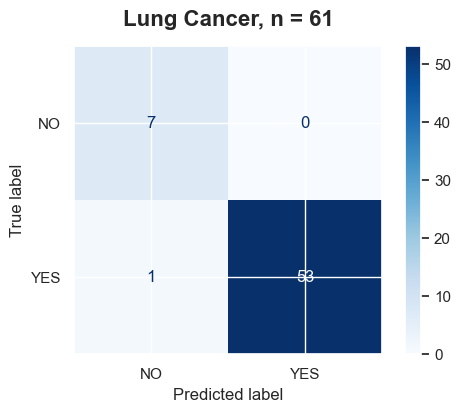

In [144]:
y_pred = rf.predict(X_test)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)
# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "YES"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Lung Cancer, n = {len(y_test)}', fontsize=16 ,weight='bold', pad=15)
plt.show()


### Feature Importance (피쳐 중요도)

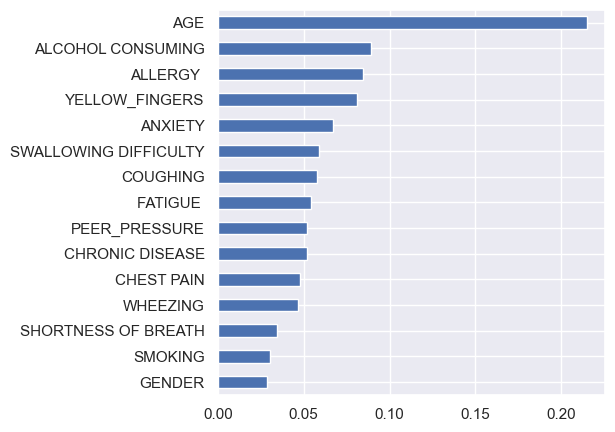

In [145]:
model_rf = rf.named_steps['randomforestclassifier']

importances = pd.Series(model_rf.feature_importances_, X_test.columns)
plt.figure(figsize=(5,5))
importances.sort_values().plot.barh();